# Trabalho Prático Final — Etapa 1  
**Disciplina:** GCC262 - Grafos e suas Aplicações  
**Instituição:** Universidade Federal de Lavras (UFLA)  
**Professor:** Mayron César O. Moreira  
**Aluno:** Laura Costa Sarto Barboza

## ✅ Objetivo

Este projeto tem como objetivo realizar o pré-processamento de dados de instâncias de grafos para um problema de roteamento com restrições. A etapa 1 consiste em:

- Representar o problema com estruturas de dados adequadas;
- Implementar a leitura dos arquivos `.dat` no formato proposto pelo professor;
- Calcular e apresentar métricas relevantes sobre os grafos;
- Gerar visualizações com apoio da biblioteca `pandas`.

---

## 🧠 Como o problema foi modelado

O grafo é representado como um **multigrafo direcionado e não direcionado**, onde:

- **Vértices (`self.conjunto_vertices`)**: conjunto de nós presentes no grafo.
- **Lista de adjacência (`self.lista_adjacencia`)**: armazena os vizinhos e seus custos de cada vértice.
- **Arestas requeridas (`self.arestas_requeridas`)**: subconjunto de arestas não direcionadas que precisam ser atendidas.
- **Arcos requeridos (`self.arcos_requeridos`)**: subconjunto de arcos direcionados que precisam ser atendidos.
- **Vértices requeridos (`self.vertices_requeridos`)**: nós com demanda direta.
- **Capacidade (`self.capacidade_veiculo`)** e **depósito (`self.vertice_deposito`)**: parâmetros logísticos da instância.

Essas estruturas foram implementadas com `set()` e `defaultdict(list)`, todos da Standard Library do Python.

---

## 🗃️ Leitura dos dados

A função `carregar_arquivo(caminho)` interpreta arquivos `.dat` estruturados conforme o modelo fornecido.

As seções do arquivo reconhecidas são:

- `Depot Node:` → define o vértice do depósito
- `Capacity:` → define a capacidade dos veículos
- `ReN.` → vértices requeridos
- `ReE.` → arestas requeridas (não direcionadas)
- `ReA.` → arcos requeridos (direcionados)

A função trata as linhas com cuidado, ignora comentários e cabeçalhos, e converte nomes como `N4`, `E1` e `A1` para inteiros relevantes, preenchendo as estruturas do grafo.

---

## 📊 Métricas calculadas

A função `gerar_tabela()` gera duas tabelas usando `pandas`:

### 🔹 Estatísticas gerais do grafo

| Métrica                   | Descrição |
|---------------------------|-----------|
| Qtd Vértices              | Total de nós distintos |
| Qtd Arestas               | Total de arestas requeridas |
| Qtd Arcos                 | Total de arcos requeridos |
| Vértices Requeridos       | Nós com demanda direta |
| Arestas/Arcos Requeridas  | Elementos que devem ser atendidos |
| Densidade                 | Relação entre número de conexões e o total possível |
| Componentes Conectados    | Subgrafos conexos disjuntos |
| Grau Mínimo / Máximo      | Número mínimo/máximo de conexões por vértice |
| Caminho Médio             | Média das distâncias entre todos os pares |
| Diâmetro                  | Maior distância entre dois nós |

### 🔹 Intermediação (betweenness)

Calcula quantas vezes um vértice aparece nos caminhos mais curtos entre outros pares de vértices.

---

## 📈 Justificativa da escolha do algoritmo de caminhos mínimos

Para o cálculo de métricas como **caminho médio**, **diâmetro** e principalmente **intermediação (betweenness)**, é necessário conhecer os **menores caminhos entre todos os pares de vértices do grafo** — o que é conhecido como o problema de **All-Pairs Shortest Paths (APSP)**.

Neste trabalho, foi utilizado o **algoritmo de Floyd-Warshall**, devido às seguintes razões:

- É um algoritmo **simples de implementar** e bem adaptado para estruturas matriciais;
- Calcula o menor caminho entre **todos os pares de vértices** em tempo \( O(V^3) \), sendo adequado para os tamanhos das instâncias fornecidas;
- É eficaz mesmo em grafos **não direcionados ou com pesos negativos**, desde que não existam ciclos negativos;
- Permite derivar facilmente a **matriz de predecessores**, necessária para a reconstrução dos caminhos mínimos utilizados na métrica de intermediação.

Embora existam alternativas como o **algoritmo de Dijkstra**, que apresenta melhor desempenho assintótico quando otimizado com estruturas como heaps, ele exige múltiplas execuções (uma por vértice), o que tornaria a implementação mais complexa sem ganho significativo para os tamanhos de instância utilizados aqui.

---

## 💻 Bibliotecas utilizadas

Somente bibliotecas **da Standard Library** :

- `collections.defaultdict` – lista de adjacência eficiente
- `collections.deque` – fila para BFS
- `math.inf` – usado no algoritmo de Floyd-Warshall
- `pandas` – permitido no `.ipynb` para visualização das tabelas

---

## ▶️ Como usar

1. No seu notebook `.ipynb`, importe o arquivo `.py` ou copie a classe `Grafo`.
2. Utilize o seguinte exemplo para executar:

```python
g = Grafo()
g.carregar_instancia("./selected_instances/BHW1.dat")  # ou qualquer outro .dat
geral, intermediacao = g.gerar_tabelas_resultado()
display(geral)
display(intermediacao.sort_values(by="Intermediação", ascending=False))
```

---

## 📁 Visualização (opcional)

Você pode plotar um gráfico da intermediação com:

```python
import matplotlib.pyplot as plt

intermediacao.sort_values(by="Intermediação", ascending=False).plot(kind="bar")
plt.title("Intermediação por vértice")
plt.xlabel("Vértice")
plt.ylabel("Intermediação")
plt.grid(True)
plt.show()
```



In [2]:
# Trabalho Etapa 1 - GCC262
# Aluno: Laura Costa Sarto Barboza

# --------------------------------------------------
# Importação de bibliotecas permitidas
# --------------------------------------------------
import pandas as pd
from collections import defaultdict, deque
import math
import matplotlib.pyplot as plt

# --------------------------------------------------
# Classe para representação e análise de grafos
# --------------------------------------------------
class Grafo:
    def __init__(self):
        self.conjunto_vertices = set()
        self.lista_adjacencia = defaultdict(list)
        self.arestas_requeridas = set()
        self.arcos_requeridos = set()
        self.vertices_requeridos = set()
        self.capacidade_veiculo = 0
        self.vertice_deposito = None

    def carregar_instancia(self, caminho_arquivo):
        with open(caminho_arquivo, 'r') as arquivo:
            linhas = [linha.strip() for linha in arquivo if linha.strip()]

        secao_atual = None
        for linha in linhas:
            if linha.startswith("Depot Node"):
                self.vertice_deposito = int(linha.split()[2])
            elif linha.startswith("Capacity"):
                self.capacidade_veiculo = int(linha.split()[1])
            elif linha.startswith("ReN."):
                secao_atual = 'vertices'
                continue
            elif linha.startswith("ReE."):
                secao_atual = 'arestas'
                continue
            elif linha.startswith("ReA."):
                secao_atual = 'arcos'
                continue
            elif linha.startswith("#") or "." in linha:
                secao_atual = None
                continue

            if secao_atual == 'vertices':
                partes = linha.split("\t")
                if len(partes) >= 1:
                    id_vertice = int(partes[0][1:])
                    self.conjunto_vertices.add(id_vertice)
                    self.vertices_requeridos.add(id_vertice)

            elif secao_atual == 'arestas':
                partes = linha.split("\t")
                if len(partes) >= 6:
                    origem = int(partes[1])
                    destino = int(partes[2])
                    custo = int(partes[3])
                    self.conjunto_vertices.update([origem, destino])
                    self.lista_adjacencia[origem].append((destino, custo))
                    self.lista_adjacencia[destino].append((origem, custo))
                    self.arestas_requeridas.add(tuple(sorted((origem, destino))))

            elif secao_atual == 'arcos':
                partes = linha.split("\t")
                if len(partes) >= 6:
                    origem = int(partes[1])
                    destino = int(partes[2])
                    custo = int(partes[3])
                    self.conjunto_vertices.update([origem, destino])
                    self.lista_adjacencia[origem].append((destino, custo))
                    self.arcos_requeridos.add((origem, destino))

    def calcular_densidade(self):
        n = len(self.conjunto_vertices)
        m = sum(len(v) for v in self.lista_adjacencia.values()) // 2
        if n <= 1:
            return 0
        return m / (n * (n - 1) / 2)

    def contar_componentes_conectados(self):
        visitados = set()
        total_componentes = 0

        def bfs(v):
            fila = deque([v])
            visitados.add(v)
            while fila:
                atual = fila.popleft()
                for vizinho, _ in self.lista_adjacencia[atual]:
                    if vizinho not in visitados:
                        visitados.add(vizinho)
                        fila.append(vizinho)

        for vertice in self.conjunto_vertices:
            if vertice not in visitados:
                bfs(vertice)
                total_componentes += 1
        return total_componentes

    def calcular_graus(self):
        graus = [len(self.lista_adjacencia[v]) for v in self.conjunto_vertices if v in self.lista_adjacencia]
        if not graus:
            return 0, 0
        return min(graus), max(graus)

    def floyd_warshall(self):
        V = list(self.conjunto_vertices)
        idx = {v: i for i, v in enumerate(V)}
        n = len(V)
        dist = [[math.inf] * n for _ in range(n)]
        pred = [[-1] * n for _ in range(n)]

        for i in range(n):
            dist[i][i] = 0

        for u in self.lista_adjacencia:
            for v, c in self.lista_adjacencia[u]:
                i, j = idx[u], idx[v]
                dist[i][j] = c
                pred[i][j] = i

        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
                        pred[i][j] = pred[k][j]

        return dist, pred, V

    def calcular_caminho_medio_diametro(self, dist):
        total = 0
        cont = 0
        diam = 0
        for i in range(len(dist)):
            for j in range(len(dist)):
                if i != j and dist[i][j] < math.inf:
                    total += dist[i][j]
                    cont += 1
                    diam = max(diam, dist[i][j])
        caminho_medio = total / cont if cont > 0 else 0
        return caminho_medio, diam

    def calcular_intermediacao(self, dist, pred, V):
        n = len(V)
        inter = {v: 0 for v in V}
        for i in range(n):
            for j in range(n):
                if i == j or dist[i][j] == math.inf:
                    continue
                caminho = []
                atual = j
                while atual != i and atual != -1:
                    caminho.append(V[atual])
                    atual = pred[i][atual]
                for v in caminho[1:-1]:
                    inter[v] += 1
        return inter

    def gerar_tabelas_resultado(self):
        densidade = self.calcular_densidade()
        componentes = self.contar_componentes_conectados()
        grau_min, grau_max = self.calcular_graus()
        dist, pred, V = self.floyd_warshall()
        caminho_medio, diametro = self.calcular_caminho_medio_diametro(dist)
        inter = self.calcular_intermediacao(dist, pred, V)

        tabela = {
            "Qtd Vértices": len(self.conjunto_vertices),
            "Qtd Arestas": len(self.arestas_requeridas),
            "Qtd Arcos": len(self.arcos_requeridos),
            "Vértices Requeridos": len(self.vertices_requeridos),
            "Arestas Requeridas": len(self.arestas_requeridas),
            "Arcos Requeridos": len(self.arcos_requeridos),
            "Densidade": densidade,
            "Componentes Conectados": componentes,
            "Grau Mínimo": grau_min,
            "Grau Máximo": grau_max,
            "Caminho Médio": caminho_medio,
            "Diâmetro": diametro
        }

        df_geral = pd.DataFrame([tabela])
        df_intermediacao = pd.DataFrame.from_dict(inter, orient='index', columns=['Intermediação'])

        return df_geral, df_intermediacao


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Exemplo de uso:
grafo = Grafo()
grafo.carregar_instancia("./selected_instances/BHW1.dat")
geral, intermediacao = grafo.gerar_tabelas_resultado()
display(geral)
display(intermediacao.sort_values(by="Intermediação", ascending=False))

NameError: name 'Grafo' is not defined

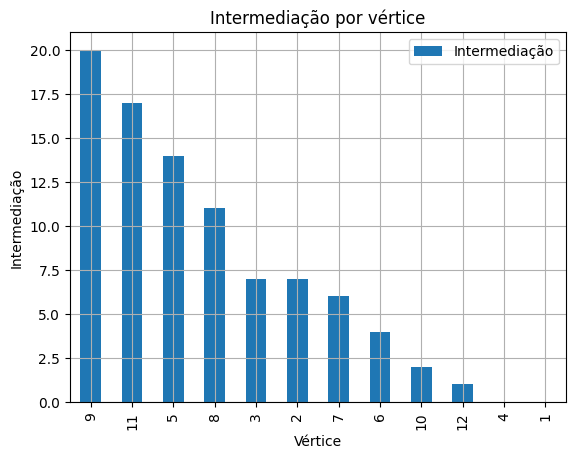

In [ ]:
# Grafico de intermediação

import matplotlib.pyplot as plt

intermediacao.sort_values(by="Intermediação", ascending=False).plot(kind="bar")
plt.title("Intermediação por vértice")
plt.xlabel("Vértice")
plt.ylabel("Intermediação")
plt.grid(True)
plt.show()